In [1]:
import os
import re
import sys
import numpy as np
import periodictable as pt
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import DBSCAN
from sklearn import decomposition
import seaborn as sns
import sklearn.datasets as data
import pandas as pd

import hdbscan
import umap.umap_ as umap

#add the parent folder to sys path so we can import from the notebook subfolder
sys.path.insert(0,'..')



BASEDIR = "/home/lachlan/"
TIFDIR = "DATA/datasets/XFMDATA/Zoe/slides_99um/s3"
EXT='.tiff'

image_directory = os.path.join(BASEDIR, TIFDIR)

/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s3
['/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s3/S3_99um_cali-Al.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s3/S3_99um_cali-As.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s3/S3_99um_cali-Ca.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s3/S3_99um_cali-Cl.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s3/S3_99um_cali-Cr.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s3/S3_99um_cali-Cu.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s3/S3_99um_cali-Fe.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s3/S3_99um_cali-K.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s3/S3_99um_cali-Mg.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s3/S3_99um_cali-Mn.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s3/S3_99um_cali-Na.tiff', '/home/lachlan/DATA/datasets/XFMDATA/Zoe/slides_99um/s3/S3_99um_cali-Ni.tiff

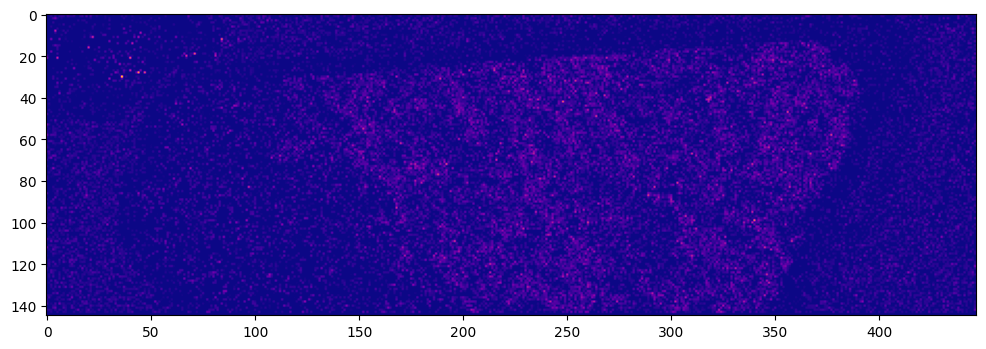

17
(64815,)
-1
0
15


../xfmreadout/processed_plots.py:88: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/seaborn/axisgrid.py:1826: UserWarning: 
The palette list has fewer values (15) than needed (17) and will cycle, which may produce an uninterpretable plot.
  func(x=self.x, y=self.y, **kwargs)
/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/seaborn/axisgrid.py:1877: UserWarning: 
The palette list has fewer values (15) than needed (17) and will cycle, which may produce an uninterpretable plot.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/seaborn/axisgrid.py:1883: UserWarning: 
The palette list has fewer values (15) than needed (17) and will cycle, which may produce an uninterpretable plot.
  f

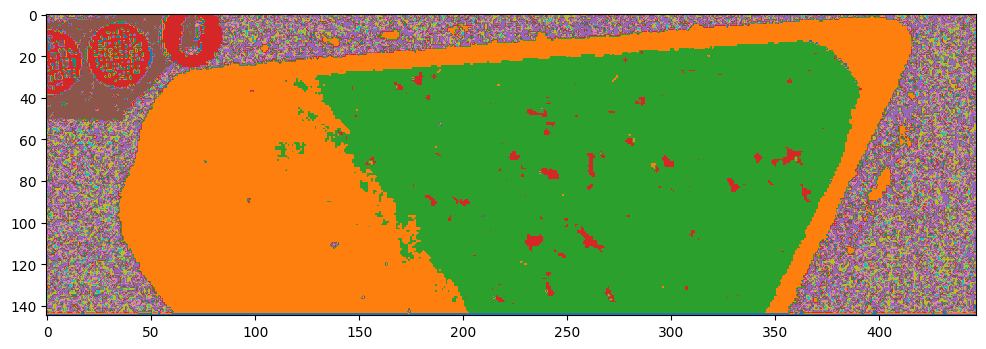

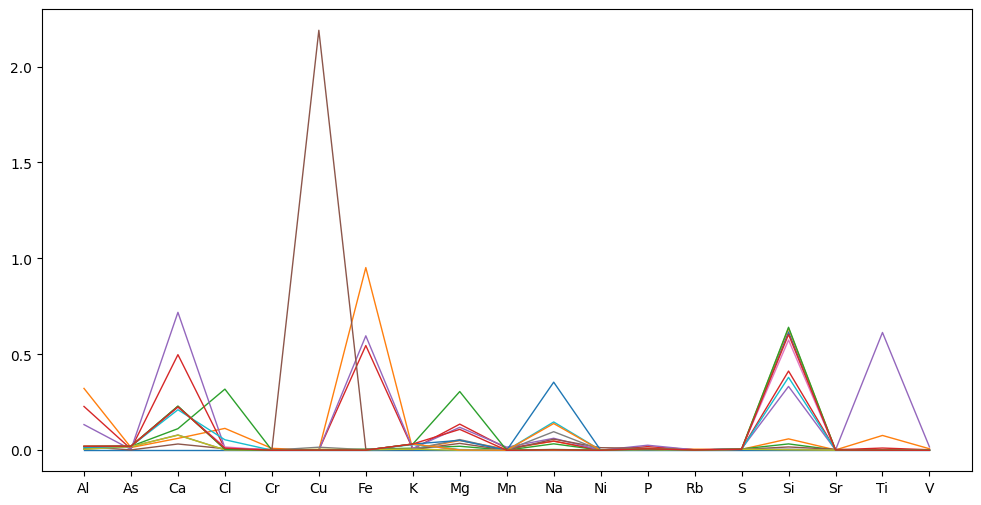

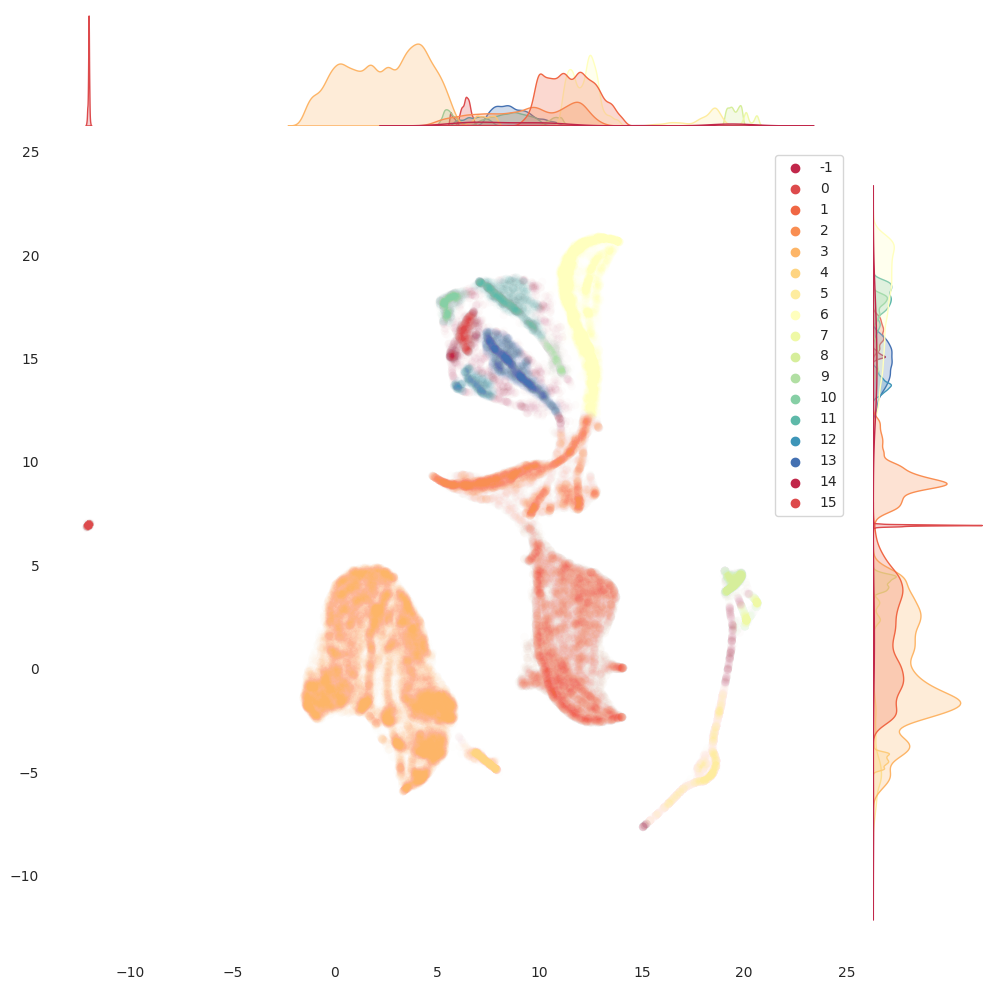

In [2]:
%load_ext autoreload
%autoreload 2

import xfmreadout.clustering as clustering
import xfmreadout.processed_ops as processed_ops
import xfmreadout.processed_plots as processed_plots

FORCE=False

data, elements, dims = processed_ops.get_data(image_directory)

categories, classavg, embedding, clusttimes, data, dims = processed_ops.process(data, dims, image_directory, force=FORCE)

processed_ops.plot_all(categories, classavg, embedding, data, elements, dims)



In [3]:
palette=sns.color_palette("Spectral",15)

dir(palette)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_repr_html_',
 'append',
 'as_hex',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

In [7]:
print(palette.as_hex())

['#c1274a', '#dd4a4c', '#f06744', '#f98e52', '#fdb567', '#fed481', '#feec9f', '#ffffbe', '#eff9a6', '#d6ee9b', '#b1dfa3', '#86cfa5', '#5eb9a9', '#3d95b8', '#4471b2']


<AxesSubplot:ylabel='$\\lambda$ value'>

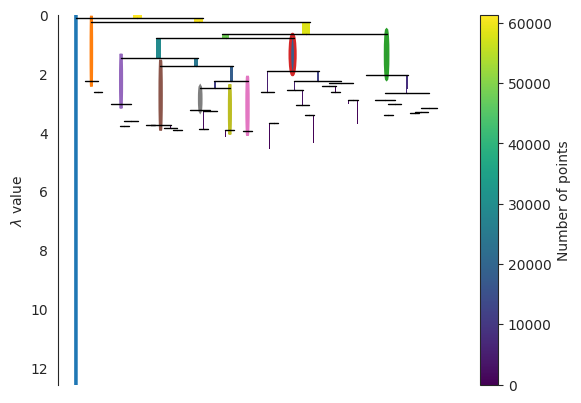

In [77]:
from sklearn.cluster import DBSCAN
from sklearn import decomposition
import hdbscan
import umap.umap_ as umap

n_clusters=10
n_channels=data.shape[1]
totalpx=data.shape[0]

def dodbscan(embed, npx):
    """
    performs kmeans on embedding matrices to cluster 2D matrices from reducers 

    args:       set of 2D embedding matrices (shape [nreducers,x,y]), number of pixels in map
    returns:    category-by-pixel matrix, shape [nreducers,chan]
    """
    #initialise kwargs
    dbscan = hdbscan.HDBSCAN(
        min_cluster_size=200,
        min_samples=100,
        cluster_selection_epsilon=0.01,
        gen_min_span_tree=True
    )

    dbscan.fit(embed)
    dbcategories=dbscan.labels_

    return dbscan, dbcategories

dbscan, categoriesdb = dodbscan(embedding, totalpx)

#produce and save cluster averages
"""
#   initialise averages
classavgdb=np.zeros([len(reducers),n_clusters, n_channels])

#   cycle through reducers
for i in range(len(reducers)):
    classavgdb[i]=clustering.sumclusters(data, categoriesdb[i], n_clusters, n_channels)    

"""

dbscan.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [14]:
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(dbscan.labels_, dbscan.probabilities_)]
plt.scatter(embedding[:,0].T, embedding[:,1].T, c=cluster_colors, **plot_kwds)

NameError: name 'dbscan' is not defined

In [88]:
sns.color_palette("deep", 8, as_cmap=True)

['#4C72B0',
 '#DD8452',
 '#55A868',
 '#C44E52',
 '#8172B3',
 '#937860',
 '#DA8BC3',
 '#8C8C8C',
 '#CCB974',
 '#64B5CD']

In [77]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]